In [1]:
# Importieren der benötigten Bibliotheken

# Datenmanipulation
import pandas as pd
import numpy as np

# Visualisierung
import seaborn as sns
import matplotlib.pyplot as plt

# Eigene Module
from dpp.data import load_from_kaggle


c:\Users\IAmBlindNotDeaf\Desktop\StackFuel Weiterbildung\Abschlussprojekt\Dpp-Stackfuel-Data-Science\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparation


**Gather Data**


In [2]:
# Daten von Kaggle herunterladen
dataset_link = "thedevastator/improving-naval-vessel-condition-through-machine" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw\improving-naval-vessel-condition-through-machine' already exists with files. Skipping download (replace=False).


In [3]:
# Anzeigen der heruntergeladenen Daten
files

['data.csv']

In [4]:
# Einlesen der Daten
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]), index_col=0)
df.head()

,Lever position,Ship speed (v),Gas Turbine (GT) shaft torque (GTT) [kN m],GT rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],Hight Pressure (HP) Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],GT exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient,GT Turbine decay state coefficient
index,,,,,,,,,,,,,,,,,,
0,1.138,3,289.964,1349.489,6677.380,7.584,7.584,464.006,288,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6,6960.180,1376.166,6828.469,28.204,28.204,635.401,288,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9,8379.229,1386.757,7111.811,60.358,60.358,606.002,288,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12,14724.395,1547.465,7792.630,113.774,113.774,661.471,288,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15,21636.432,1924.313,8494.777,175.306,175.306,731.494,288,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


# Explorative Datenanalayse (EDA)


**Understand Data**


In [5]:
# Erste Übersicht über die Daten
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)

# Übersicht über die Spalten
pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


'Shape'

(11934, 18)

'Description'

,Lever position,Ship speed (v),Gas Turbine (GT) shaft torque (GTT) [kN m],GT rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],Hight Pressure (HP) Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],GT exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient,GT Turbine decay state coefficient
count,11934.00,11934.00,11934.00,11934.00,11934.00,11934.00,11934.00,11934.00,11934.0,11934.00,11934.00,11934.0,11934.00,11934.00,11934.00,11934.00,11934.00,11934.00
mean,5.17,15.00,27247.50,2136.29,8200.95,227.34,227.34,735.50,288.0,646.22,2.35,1.0,12.30,1.03,33.64,0.66,0.98,0.99
std,2.63,7.75,22148.61,774.08,1091.32,200.50,200.50,173.68,0.0,72.68,1.08,0.0,5.34,0.01,25.84,0.51,0.01,0.01
min,1.14,3.00,253.55,1307.68,6589.00,5.30,5.30,442.36,288.0,540.44,1.09,1.0,5.83,1.02,0.00,0.07,0.95,0.98
25%,3.14,9.00,8375.88,1386.76,7058.32,60.32,60.32,589.87,288.0,578.09,1.39,1.0,7.45,1.02,13.68,0.25,0.96,0.98
50%,5.14,15.00,21630.66,1924.33,8482.08,175.27,175.27,706.04,288.0,637.14,2.08,1.0,11.09,1.03,25.28,0.50,0.98,0.99
75%,7.15,21.00,39001.43,2678.08,9132.61,332.36,332.36,834.07,288.0,693.92,2.98,1.0,15.66,1.04,44.55,0.88,0.99,0.99
max,9.30,27.00,72784.87,3560.74,9797.10,645.25,645.25,1115.80,288.0,789.09,4.56,1.0,23.14,1.05,92.56,1.83,1.00,1.00


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
Lever position,float64,0,9,"[8.206, 9.3, 7.148]"
Ship speed (v),int64,0,9,"[24, 21, 6]"
Gas Turbine (GT) shaft torque (GTT) [kN m],float64,0,11430,"[29793.448, 50994.046, 14717.057]"
GT rate of revolutions (GTn) [rpm],float64,0,3888,"[1360.324, 1372.848, 1367.235]"
Gas Generator rate of revolutions (GGn) [rpm],float64,0,11834,"[9131.936, 6698.542, 6787.858]"
Starboard Propeller Torque (Ts) [kN],float64,0,4286,"[438.114, 30.994, 175.256]"
Port Propeller Torque (Tp) [kN],float64,0,4286,"[438.108, 332.315, 26.053]"
Hight Pressure (HP) Turbine exit temperature (T48) [C],float64,0,11772,"[933.352, 633.38, 818.503]"
GT Compressor inlet air temperature (T1) [C],int64,0,1,"[288, 288, 288]"
GT Compressor outlet air temperature (T2) [C],float64,0,11506,"[578.077, 640.583, 587.063]"


**Rename Columns**


In [6]:
# Bereinigen der Spaltennamen
new_cols = df.columns.str.replace(r'\s+', '_', regex=True)
new_cols = new_cols.str.rstrip('_')
df.columns = new_cols

df.head()

,Lever_position,Ship_speed_(v),Gas_Turbine_(GT)_shaft_torque_(GTT)_[kN_m],GT_rate_of_revolutions_(GTn)_[rpm],Gas_Generator_rate_of_revolutions_(GGn)_[rpm],Starboard_Propeller_Torque_(Ts)_[kN],Port_Propeller_Torque_(Tp)_[kN],Hight_Pressure_(HP)_Turbine_exit_temperature_(T48)_[C],GT_Compressor_inlet_air_temperature_(T1)_[C],GT_Compressor_outlet_air_temperature_(T2)_[C],HP_Turbine_exit_pressure_(P48)_[bar],GT_Compressor_inlet_air_pressure_(P1)_[bar],GT_Compressor_outlet_air_pressure_(P2)_[bar],GT_exhaust_gas_pressure_(Pexh)_[bar],Turbine_Injecton_Control_(TIC)_[%],Fuel_flow_(mf)_[kg/s],GT_Compressor_decay_state_coefficient,GT_Turbine_decay_state_coefficient
index,,,,,,,,,,,,,,,,,,
0,1.138,3,289.964,1349.489,6677.380,7.584,7.584,464.006,288,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6,6960.180,1376.166,6828.469,28.204,28.204,635.401,288,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9,8379.229,1386.757,7111.811,60.358,60.358,606.002,288,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12,14724.395,1547.465,7792.630,113.774,113.774,661.471,288,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15,21636.432,1924.313,8494.777,175.306,175.306,731.494,288,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


In [7]:
# Entfernen irrelevanter Spalten
df = df.drop(["GT_Compressor_inlet_air_temperature_(T1)_[C]", "GT_Compressor_inlet_air_pressure_(P1)_[bar]"], axis=1) # gleicher Wert in allen Zeilen
df = df.drop("Lever_position", axis=1) # redundante Spalte zur Spalte Ship_speed_(v)

**Outliers Detection**


In [8]:
# Aufteilen in Features und Targets
features = df.columns[:-2].tolist()
targets = df.columns[-2:].tolist()

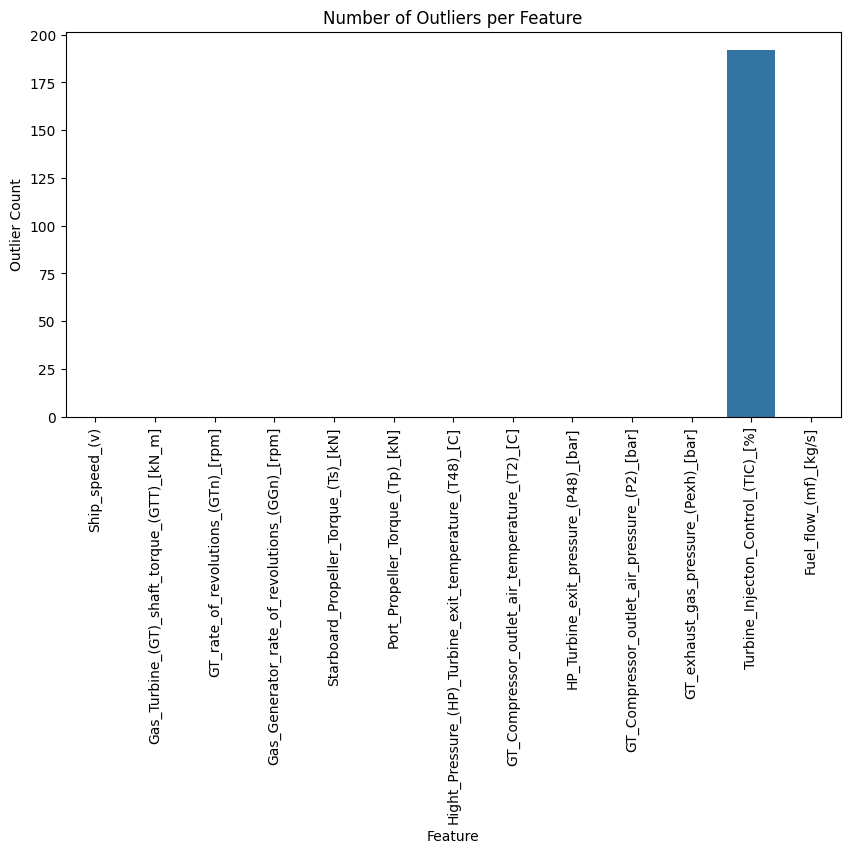

In [9]:
# IQR-Methode zur Erkennung von Ausreißern
outlier_counts = {}
for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

if outlier_counts:
    outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Feature', y='Outlier Count', data=outlier_df)
    plt.xticks(rotation=90)
    plt.title("Number of Outliers per Feature")
    plt.show()

**Check Correlations**


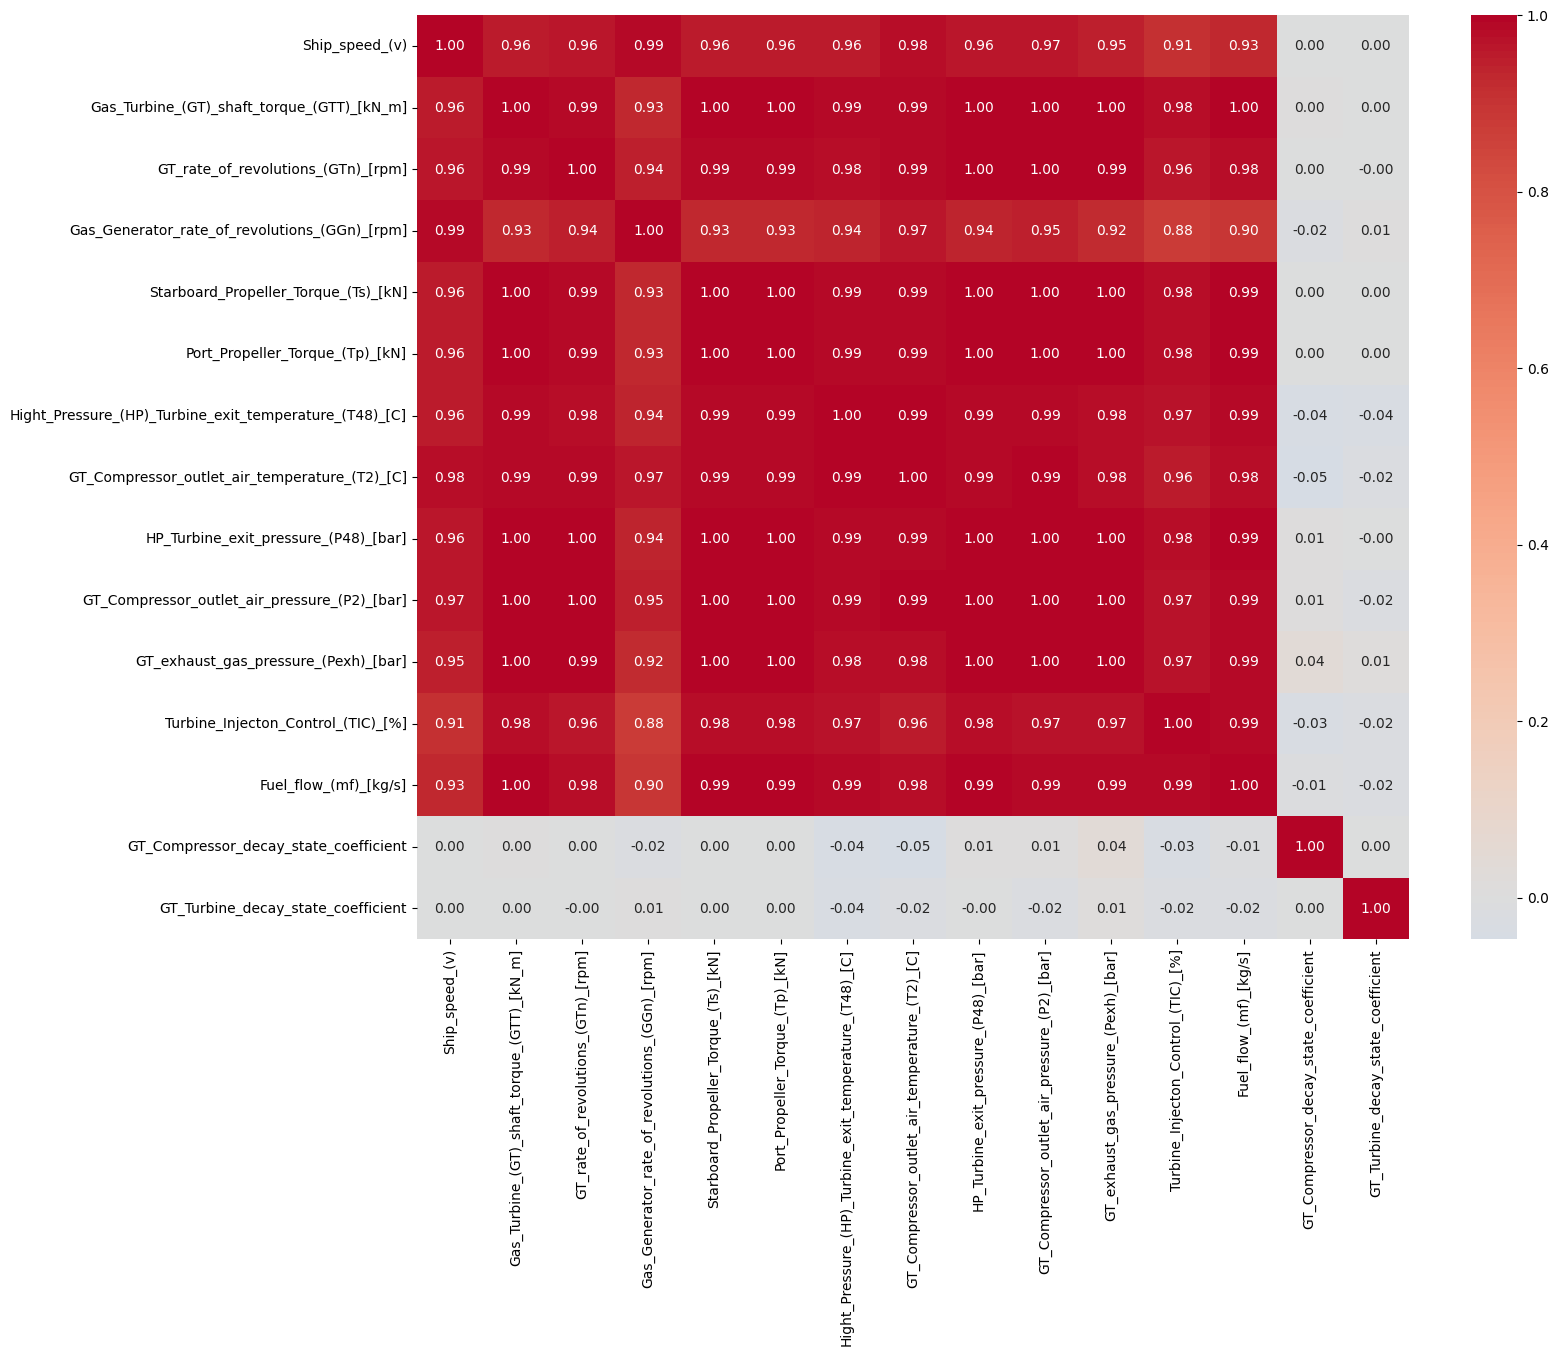

In [10]:
# Korrelationen visualisieren
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", center=0);

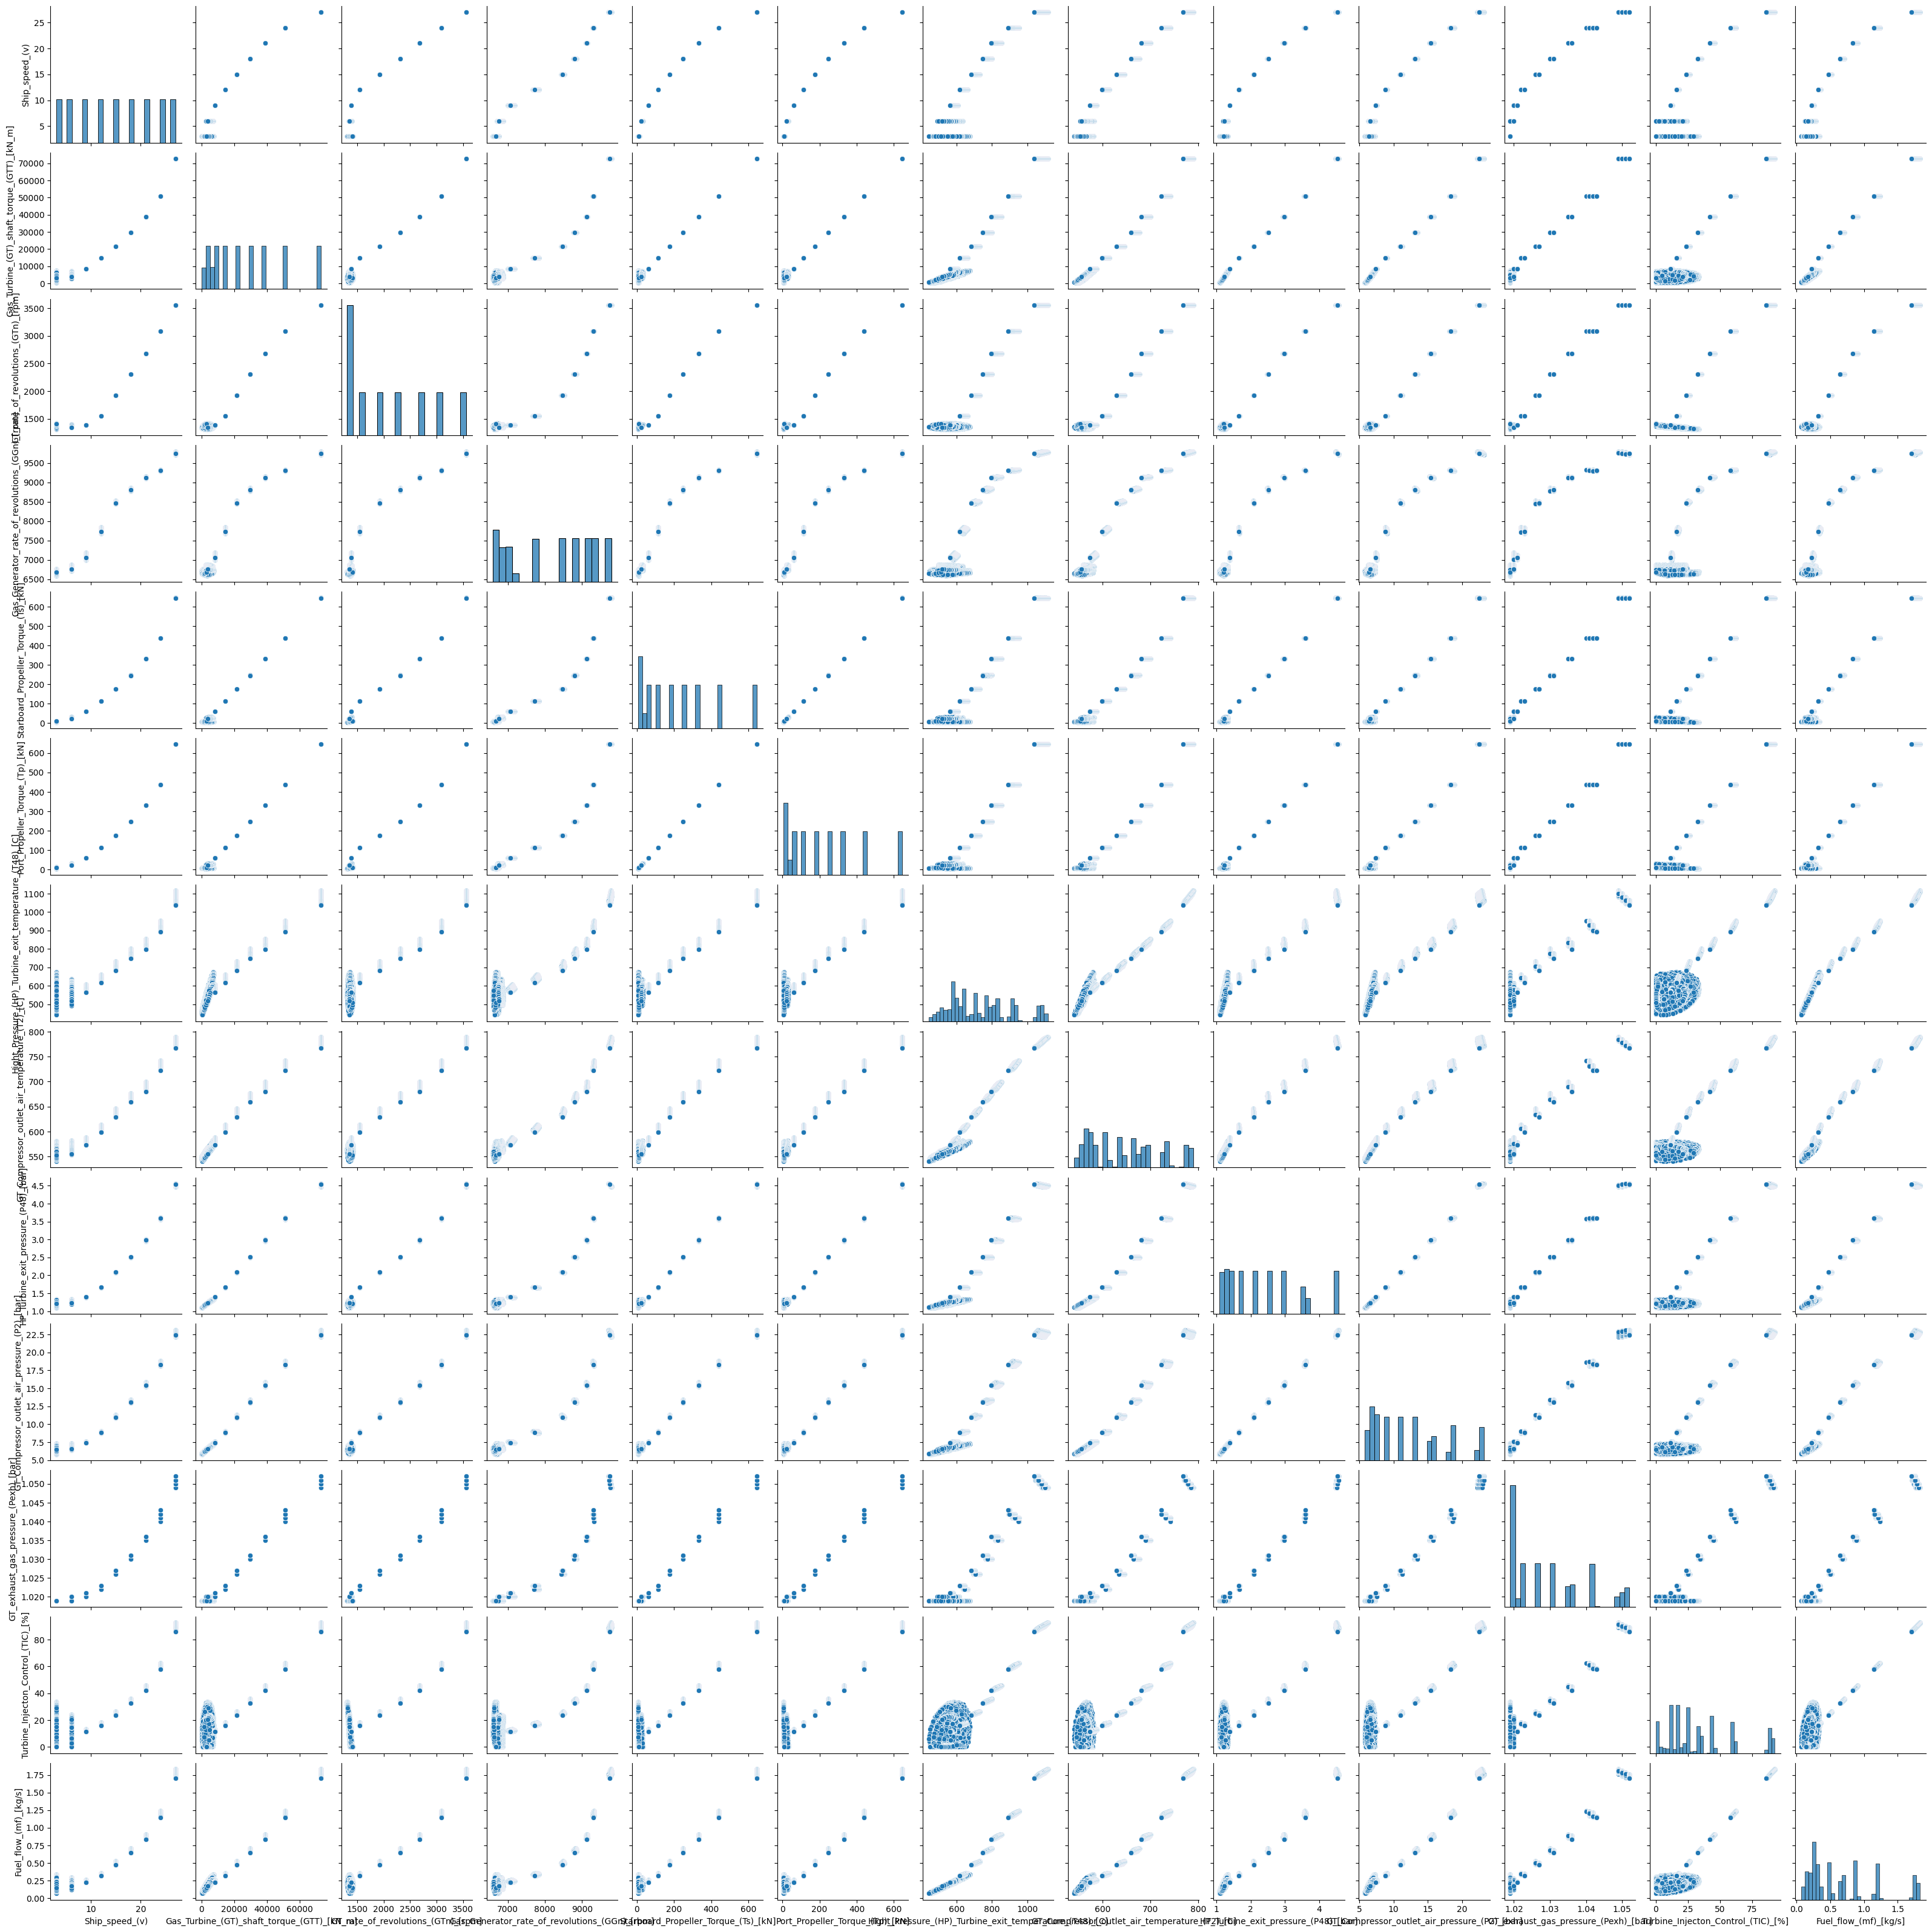

In [11]:
# Visualisierung der bivariate Beziehungen
sns.pairplot(df[features])

In [12]:
# Speichern der bereinigten Daten
df.to_csv("../data/processed/cleaned_data.csv", index=False)